# Assignment 01: Multi-class Classification 
In this Assignment, you will train a deep model on the CIFAR10 from the scratch using PyTorch.

### Basic Imports

In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

from sklearn import metrics as ms #统计库
import torchvision

import matplotlib.pyplot as plt
from PIL import Image
import h5py
import argparse


### Hyperparameters

In [2]:
# random seed
SEED = 1 
NUM_CLASS = 10

# Training
BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL=1
SAVE_DIR = './log'

# Optimizer
LEARNING_RATE = 1e-1
MOMENTUM = 0.9
STEP=5
GAMMA=0.5


### Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### Dataset


In [4]:
# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified
Files already downloaded and verified


### Model

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
model = ConvNet()
model.to(device)

ConvNet(
  (conv1): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=288, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)

### Optimizer

In [7]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

### Task 1: per batch training/testing
---

Please denfine two function named ``train_batch`` and ``test_batch``. These functions are essential for training and evaluating machine learning models using batched data from dataloaders.

**To do**: 
1. Define the loss function i.e [nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).
2. Take the image as the input and generate the output using the pre-defined SimpleNet.
3. Calculate the loss between the output and the corresponding label using the loss function.

In [8]:
class FocalLoss(nn.Module):
    def __init__(self, num_class, gamma, alpha=None, balance_index=-1, smooth=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.num_class = num_class
        self.alpha = alpha
        self.gamma = gamma
        self.smooth = smooth
        self.size_average = size_average
 
        if self.alpha is None:
            self.alpha = torch.ones(self.num_class, 1)
        elif isinstance(self.alpha, (list, np.ndarray)):
            assert len(self.alpha) == self.num_class
            self.alpha = torch.FloatTensor(alpha).view(self.num_class, 1)
            self.alpha = self.alpha / self.alpha.sum()
        elif isinstance(self.alpha, float):
            alpha = torch.ones(self.num_class, 1)
            alpha = alpha * (1 - self.alpha)
            alpha[balance_index] = self.alpha
            self.alpha = alpha
        else:
            raise TypeError('Not support alpha type')
 
        if self.smooth is not None:
            if self.smooth < 0 or self.smooth > 1.0:
                raise ValueError('smooth value should be in [0,1]')
 
    def forward(self, input, target):
        logit = F.softmax(input, dim=1) #这里看情况选择，如果之前softmax了，后续就不用了
 
        if logit.dim() > 2:
            # N,C,d1,d2 -> N,C,m (m=d1*d2*...)
            logit = logit.view(logit.size(0), logit.size(1), -1)
            logit = logit.permute(0, 2, 1).contiguous()
            logit = logit.view(-1, logit.size(-1))
        target = target.view(-1, 1)
        epsilon = 1e-10
        alpha = self.alpha
        if alpha.device != input.device:
            alpha = alpha.to(input.device)
 
        idx = target.cpu().long()
        one_hot_key = torch.FloatTensor(target.size(0), self.num_class).zero_()
        one_hot_key = one_hot_key.scatter_(1, idx, 1)
        if one_hot_key.device != logit.device:
            one_hot_key = one_hot_key.to(logit.device)
 
        if self.smooth:
            one_hot_key = torch.clamp(
                one_hot_key, self.smooth, 1.0 - self.smooth)
        pt = (one_hot_key * logit).sum(1) + epsilon
        logpt = pt.log()
 
        gamma = self.gamma
 
        alpha = alpha[idx]
        loss = -1 * alpha * torch.pow((1 - pt), gamma) * logpt
 
        if self.size_average:
            loss = loss.mean()
        else:
            loss = loss.sum()
        return loss

In [9]:
##################### Write your answer here ##################
# Define the loss function
#def custom_loss(output, ):
#     # 自定义损失函数的计算逻辑
#     loss = ...  # 自定义的损失计算方式
#     return loss
#criterion = nn.L1Loss()
#criterion = nn.CrossEntropyLoss()
def loss_function_1():
    return nn.L1Loss()
def loss_function_2():
    return nn.CrossEntropyLoss()
def loss_function_3():
    return FocalLoss(num_class=10,gamma=0.5)
def loss_function_4():
    return FocalLoss(num_class=10,gamma=2)
def loss_function_5():
    return nn.SmoothL1Loss()
def loss_function_6():
    return FocalLoss(num_class=10,gamma=5)
#criterion =FocalLoss(num_class=10,gamma=2)
###############################################################

In [10]:
def train_batch(loss_function,model, image, target):
    """
    Perform one training batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to train.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated by the defined loss function loss_fn().
    """
    
    ##################### Write your answer here ##################
     # Set the model to evaluation mode
    criterion = loss_function
    model.eval()

    # Forward pass: compute predicted outputs by passing inputs to the model
    output = model(image)
    if isinstance(criterion, nn.L1Loss):
        output = F.softmax(output, dim=1)
    if isinstance(criterion, nn.SmoothL1Loss):
        output = F.softmax(output, dim=1)
    if isinstance(criterion, nn.KLDivLoss):
        output = F.log_softmax(output, dim=1)
       # target = target.float()  # 将目标张量转换为浮点型张量
        #target = F.softmax(target, dim=0)  # 在调整后的张量上应用 softmax 操作
    # Calculate the batch loss
    loss = criterion(output, target)
    ###############################################################

    return output, loss

In [11]:

def test_batch(loss_function,model, image, target):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################
     # Set the model to evaluation mode
    criterion = loss_function
    model.eval()

    # Forward pass: compute predicted outputs by passing inputs to the model
    output = model(image)
    if isinstance(criterion, nn.L1Loss):
        output = F.softmax(output, dim=1)
    if isinstance(criterion, nn.SmoothL1Loss):
        output = F.softmax(output, dim=1)
    if isinstance(criterion, nn.KLDivLoss):
        output = F.log_softmax(output, dim=1)
    # Calculate the batch loss
    loss = criterion(output, target)
    ###############################################################

    return output, loss

### Model Training

In [12]:
def train_and_test_model(loss_function):
    criterion = loss_function()
    training_loss = []
    training_acc = []
    testing_loss = []
    testing_acc = []
    #gradients = []  # 初始化梯度列表
    for epoch in range(NUM_EPOCHS):
        model.train()
        torch.cuda.empty_cache()

        ##########################
        ### Training
        ##########################

        running_cls_loss = 0.0
        running_cls_corrects = 0

        for batch_idx, (image, target) in enumerate(train_dataloader):
            image = image.to(device)
            target = target.to(device)
            if isinstance(criterion, nn.L1Loss):
                target_=F.one_hot(target, 10)
                outputs, loss = train_batch(criterion,model, image, target_)
            elif isinstance(criterion, nn.KLDivLoss):
                target_ = target.float()  # 将目标张量转换为浮点型张量
                target_ = F.softmax(target_, dim=0)  # 在调整后的张量上应用 softmax 操作
                outputs, loss = train_batch(criterion,model, image, target_)
            elif isinstance(criterion, nn.SmoothL1Loss):
                target_=F.one_hot(target, 10)
                outputs, loss = train_batch(criterion,model, image, target_)
            else:
            #print(target_.shape)
            # train model
                outputs, loss = train_batch(criterion,model, image, target)
            _, preds = torch.max(outputs, 1)
            
            loss_data = loss.data.item()
            if np.isnan(loss_data):
                raise ValueError('loss is nan while training')
            running_cls_loss += loss.item()
            running_cls_corrects += torch.sum(preds == target.data)

            loss.backward()
            #a = [param.grad.data.clone() for torch.tensor(param, device = 'cpu') in model.parameters()]
            #gradients.append(a)
            
            optimizer.step()
            optimizer.zero_grad()

        epoch_loss = running_cls_loss*BATCH_SIZE / len(train_set)
        epoch_acc = running_cls_corrects.double() / len(train_set)

        print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        training_loss.append(epoch_loss)
        training_acc.append(epoch_acc.cpu().detach().numpy())

        # change learning rate
        scheduler.step()

        ##########################
        ### Testing
        ##########################
        # # eval model during training or in the last epoch
        if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
            print('Begin test......')
            model.eval()

            val_loss = 0.0
            val_corrects = 0

            for batch_idx, (image, target) in enumerate(test_dataloader):

                image = image.to(device)
                target = target.to(device)
                #target_=F.one_hot(target, 10)
                # test model
                if isinstance(criterion, nn.L1Loss):
                    target_=F.one_hot(target, 10)
                    outputs, loss = train_batch(criterion,model, image, target_)
                elif isinstance(criterion, nn.SmoothL1Loss):
                    target_=F.one_hot(target, 10)
                    outputs, loss = train_batch(criterion,model, image, target_)
                else:
            #print(target_.shape)
            # train model
                    outputs, loss = train_batch(criterion,model, image, target)
                _, preds = torch.max(outputs, 1)
                
                val_loss += loss.item()
                val_corrects += torch.sum(preds == target.data)

            val_loss = val_loss*BATCH_SIZE / len(test_set)
            val_acc = val_corrects.double() / len(test_set)
            print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
            testing_loss.append(val_loss)
            testing_acc.append(val_acc.cpu().detach().numpy())

            # save the model in last epoch
            if (epoch +1) == NUM_EPOCHS:
                state = {
                'state_dict': model.state_dict(),
                'acc': epoch_acc,
                'epoch': (epoch+1),
                }

                # check the dir
                if not os.path.exists(SAVE_DIR):
                    os.makedirs(SAVE_DIR)

                # save the state
                torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

    return training_loss, training_acc, testing_loss, testing_acc


In [13]:
loss_func = loss_function_1  # 选择要调用的损失函数
training_loss, training_acc, testing_loss, testing_acc = train_and_test_model(loss_func)


Epoch: 1/30 Train Loss: 0.1709 Acc: 0.1722
Begin test......
Test Loss: 0.1529 Acc: 0.2488
Epoch: 2/30 Train Loss: 0.1530 Acc: 0.2383
Begin test......
Test Loss: 0.1492 Acc: 0.2632
Epoch: 3/30 Train Loss: 0.1501 Acc: 0.2513
Begin test......
Test Loss: 0.1476 Acc: 0.2707
Epoch: 4/30 Train Loss: 0.1485 Acc: 0.2587
Begin test......
Test Loss: 0.1464 Acc: 0.2780
Epoch: 5/30 Train Loss: 0.1482 Acc: 0.2608
Begin test......
Test Loss: 0.1478 Acc: 0.2695
Epoch: 6/30 Train Loss: 0.1465 Acc: 0.2688
Begin test......
Test Loss: 0.1438 Acc: 0.2892
Epoch: 7/30 Train Loss: 0.1456 Acc: 0.2737
Begin test......
Test Loss: 0.1423 Acc: 0.2962
Epoch: 8/30 Train Loss: 0.1450 Acc: 0.2774
Begin test......
Test Loss: 0.1423 Acc: 0.2979
Epoch: 9/30 Train Loss: 0.1430 Acc: 0.2875
Begin test......
Test Loss: 0.1376 Acc: 0.3224
Epoch: 10/30 Train Loss: 0.1393 Acc: 0.3066
Begin test......
Test Loss: 0.1345 Acc: 0.3355
Epoch: 11/30 Train Loss: 0.1378 Acc: 0.3133
Begin test......
Test Loss: 0.1324 Acc: 0.3461
Epoch: 1

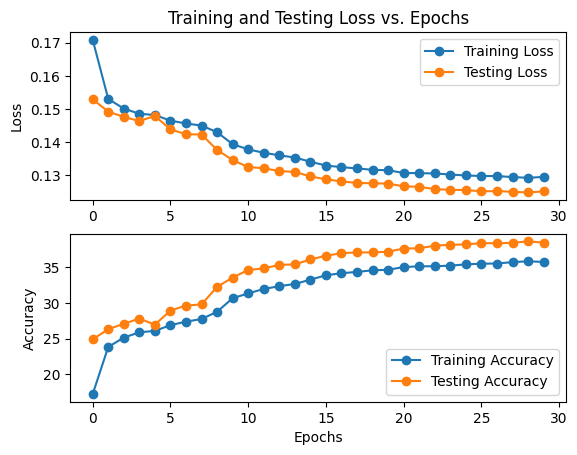

In [14]:
# 定义四个数组
train_loss_list1 = []
test_loss_list1 = []
train_acc_list1 = []
test_acc_list1 = []

# 将训练损失和准确率添加到相应的列表中
for loss in training_loss:
    train_loss_list1.append(loss)

for loss in testing_loss:
    test_loss_list1.append(loss)

for acc in training_acc:
    train_acc_list1.append(100 * acc)

for acc in testing_acc:
    test_acc_list1.append(100 * acc)

# 迭代了NUM_EPOCHS次
x = range(0, NUM_EPOCHS)

# 绘制训练损失和测试损失
plt.subplot(2, 1, 1)
plt.plot(x, train_loss_list1, label='Training Loss', marker='o')
plt.plot(x, test_loss_list1, label='Testing Loss', marker='o')
plt.title('Training and Testing Loss vs. Epochs')
plt.ylabel('Loss')
plt.legend()

# 绘制训练准确率和测试准确率
plt.subplot(2, 1, 2)
plt.plot(x, train_acc_list1, label='Training Accuracy', marker='o')
plt.plot(x, test_acc_list1, label='Testing Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 显示图形
plt.show()


In [15]:
model = ConvNet()
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)
loss_func = loss_function_2  # 选择要调用的损失函数
training_loss, training_acc, testing_loss, testing_acc = train_and_test_model(loss_func)

Epoch: 1/30 Train Loss: 1.9532 Acc: 0.2694
Begin test......
Test Loss: 1.7777 Acc: 0.3571
Epoch: 2/30 Train Loss: 1.8089 Acc: 0.3310
Begin test......
Test Loss: 1.7441 Acc: 0.3324
Epoch: 3/30 Train Loss: 1.7678 Acc: 0.3456
Begin test......
Test Loss: 1.7772 Acc: 0.3630
Epoch: 4/30 Train Loss: 1.7552 Acc: 0.3515
Begin test......
Test Loss: 1.7140 Acc: 0.3623
Epoch: 5/30 Train Loss: 1.7440 Acc: 0.3574
Begin test......
Test Loss: 1.7486 Acc: 0.3789
Epoch: 6/30 Train Loss: 1.6246 Acc: 0.4010
Begin test......
Test Loss: 1.5459 Acc: 0.4306
Epoch: 7/30 Train Loss: 1.5880 Acc: 0.4180
Begin test......
Test Loss: 1.5052 Acc: 0.4367
Epoch: 8/30 Train Loss: 1.5690 Acc: 0.4247
Begin test......
Test Loss: 1.4662 Acc: 0.4738
Epoch: 9/30 Train Loss: 1.5622 Acc: 0.4299
Begin test......
Test Loss: 1.4914 Acc: 0.4664
Epoch: 10/30 Train Loss: 1.5653 Acc: 0.4302
Begin test......
Test Loss: 1.5808 Acc: 0.4428
Epoch: 11/30 Train Loss: 1.4820 Acc: 0.4626
Begin test......
Test Loss: 1.3999 Acc: 0.5027
Epoch: 1

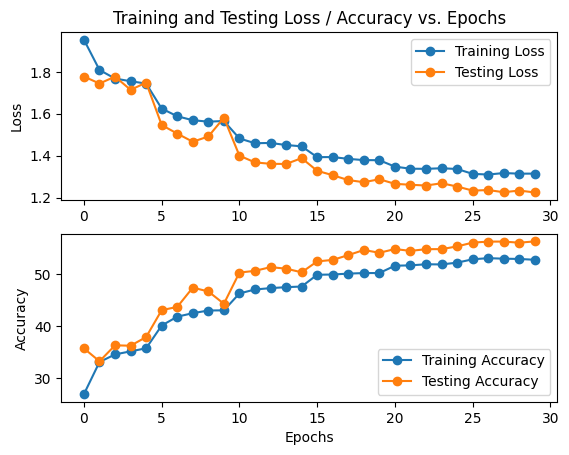

In [16]:
# 定义四个数组
train_loss_list2 = []
test_loss_list2 = []
train_acc_list2 = []
test_acc_list2 = []

# 将训练损失和准确率添加到相应的列表中
for loss in training_loss:
    train_loss_list2.append(loss)

for loss in testing_loss:
    test_loss_list2.append(loss)

for acc in training_acc:
    train_acc_list2.append(100 * acc)

for acc in testing_acc:
    test_acc_list2.append(100 * acc)

# 迭代了NUM_EPOCHS次
x = range(0, NUM_EPOCHS)

# 绘制训练损失和测试损失
plt.subplot(2, 1, 1)
plt.plot(x, train_loss_list2, label='Training Loss', marker='o')
plt.plot(x, test_loss_list2, label='Testing Loss', marker='o')
plt.title('Training and Testing Loss / Accuracy vs. Epochs')
plt.ylabel('Loss')
plt.legend()

# 绘制训练准确率和测试准确率
plt.subplot(2, 1, 2)
plt.plot(x, train_acc_list2, label='Training Accuracy', marker='o')
plt.plot(x, test_acc_list2, label='Testing Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 显示图形
plt.show()


In [17]:
model = ConvNet()
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)
loss_func = loss_function_3  # 选择要调用的损失函数
training_loss, training_acc, testing_loss, testing_acc = train_and_test_model(loss_func)

Epoch: 1/30 Train Loss: 1.8919 Acc: 0.2380
Begin test......
Test Loss: 1.7062 Acc: 0.3187
Epoch: 2/30 Train Loss: 1.6810 Acc: 0.3148
Begin test......
Test Loss: 1.5668 Acc: 0.3591
Epoch: 3/30 Train Loss: 1.6109 Acc: 0.3395
Begin test......
Test Loss: 1.5182 Acc: 0.3789
Epoch: 4/30 Train Loss: 1.6020 Acc: 0.3457
Begin test......
Test Loss: 1.4851 Acc: 0.3954
Epoch: 5/30 Train Loss: 1.5964 Acc: 0.3494
Begin test......
Test Loss: 1.5857 Acc: 0.3551
Epoch: 6/30 Train Loss: 1.4923 Acc: 0.3847
Begin test......
Test Loss: 1.3918 Acc: 0.4306
Epoch: 7/30 Train Loss: 1.4699 Acc: 0.3949
Begin test......
Test Loss: 1.4112 Acc: 0.4212
Epoch: 8/30 Train Loss: 1.4481 Acc: 0.4061
Begin test......
Test Loss: 1.4165 Acc: 0.4217
Epoch: 9/30 Train Loss: 1.4404 Acc: 0.4113
Begin test......
Test Loss: 1.3614 Acc: 0.4432
Epoch: 10/30 Train Loss: 1.4417 Acc: 0.4095
Begin test......
Test Loss: 1.3484 Acc: 0.4514
Epoch: 11/30 Train Loss: 1.3663 Acc: 0.4400
Begin test......
Test Loss: 1.2728 Acc: 0.4888
Epoch: 1

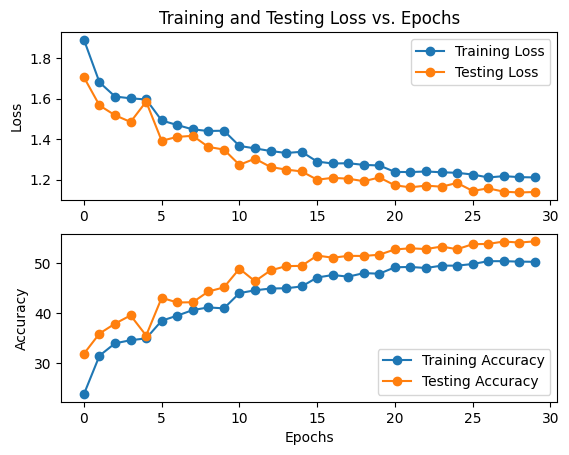

In [18]:
# 定义四个数组
train_loss_list3 = []
test_loss_list3 = []
train_acc_list3 = []
test_acc_list3 = []

# 将训练损失和准确率添加到相应的列表中
for loss in training_loss:
    train_loss_list3.append(loss)

for loss in testing_loss:
    test_loss_list3.append(loss)

for acc in training_acc:
    train_acc_list3.append(100 * acc)

for acc in testing_acc:
    test_acc_list3.append(100 * acc)

# 迭代了NUM_EPOCHS次
x = range(0, NUM_EPOCHS)

# 绘制训练损失和测试损失
plt.subplot(2, 1, 1)
plt.plot(x, train_loss_list3, label='Training Loss', marker='o')
plt.plot(x, test_loss_list3, label='Testing Loss', marker='o')
plt.title('Training and Testing Loss vs. Epochs')
plt.ylabel('Loss')
plt.legend()

# 绘制训练准确率和测试准确率
plt.subplot(2, 1, 2)
plt.plot(x, train_acc_list3, label='Training Accuracy', marker='o')
plt.plot(x, test_acc_list3, label='Testing Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 显示图形
plt.show()


In [19]:
model = ConvNet()
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)
loss_func = loss_function_4  # 选择要调用的损失函数
training_loss, training_acc, testing_loss, testing_acc = train_and_test_model(loss_func)

Epoch: 1/30 Train Loss: 1.5109 Acc: 0.2421
Begin test......
Test Loss: 1.2959 Acc: 0.3286
Epoch: 2/30 Train Loss: 1.3478 Acc: 0.2977
Begin test......
Test Loss: 1.2338 Acc: 0.3460
Epoch: 3/30 Train Loss: 1.2832 Acc: 0.3225
Begin test......
Test Loss: 1.1697 Acc: 0.3750
Epoch: 4/30 Train Loss: 1.3027 Acc: 0.3237
Begin test......
Test Loss: 1.2309 Acc: 0.3646
Epoch: 5/30 Train Loss: 1.2676 Acc: 0.3344
Begin test......
Test Loss: 1.1601 Acc: 0.3839
Epoch: 6/30 Train Loss: 1.1666 Acc: 0.3748
Begin test......
Test Loss: 1.0857 Acc: 0.4157
Epoch: 7/30 Train Loss: 1.1319 Acc: 0.3876
Begin test......
Test Loss: 1.0303 Acc: 0.4339
Epoch: 8/30 Train Loss: 1.1191 Acc: 0.4001
Begin test......
Test Loss: 1.0259 Acc: 0.4469
Epoch: 9/30 Train Loss: 1.0989 Acc: 0.4097
Begin test......
Test Loss: 1.0293 Acc: 0.4496
Epoch: 10/30 Train Loss: 1.0894 Acc: 0.4105
Begin test......
Test Loss: 1.0055 Acc: 0.4563
Epoch: 11/30 Train Loss: 1.0246 Acc: 0.4428
Begin test......
Test Loss: 0.9163 Acc: 0.5021
Epoch: 1

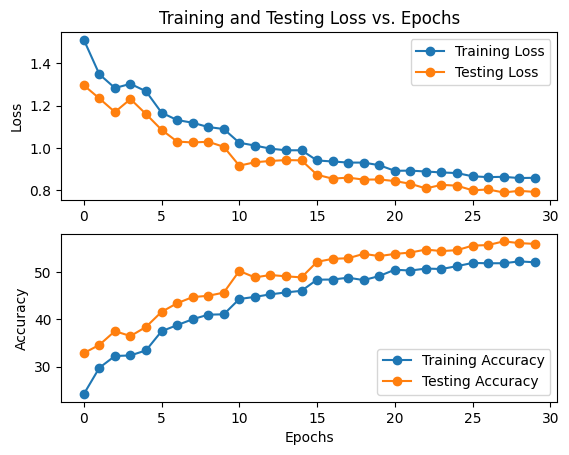

In [20]:
# 定义四个数组
train_loss_list4 = []
test_loss_list4 = []
train_acc_list4 = []
test_acc_list4 = []

# 将训练损失和准确率添加到相应的列表中
for loss in training_loss:
    train_loss_list4.append(loss)

for loss in testing_loss:
    test_loss_list4.append(loss)

for acc in training_acc:
    train_acc_list4.append(100 * acc)

for acc in testing_acc:
    test_acc_list4.append(100 * acc)

# 迭代了NUM_EPOCHS次
x = range(0, NUM_EPOCHS)

# 绘制训练损失和测试损失
plt.subplot(2, 1, 1)
plt.plot(x, train_loss_list4, label='Training Loss', marker='o')
plt.plot(x, test_loss_list4, label='Testing Loss', marker='o')
plt.title('Training and Testing Loss vs. Epochs')
plt.ylabel('Loss')
plt.legend()

# 绘制训练准确率和测试准确率
plt.subplot(2, 1, 2)
plt.plot(x, train_acc_list4, label='Training Accuracy', marker='o')
plt.plot(x, test_acc_list4, label='Testing Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 显示图形
plt.show()


In [21]:
model = ConvNet()
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)
loss_func = loss_function_5  # 选择要调用的损失函数
training_loss, training_acc, testing_loss, testing_acc = train_and_test_model(loss_func)

Epoch: 1/30 Train Loss: 0.0446 Acc: 0.1595
Begin test......
Test Loss: 0.0440 Acc: 0.2139
Epoch: 2/30 Train Loss: 0.0425 Acc: 0.2427
Begin test......
Test Loss: 0.0414 Acc: 0.2995
Epoch: 3/30 Train Loss: 0.0408 Acc: 0.2998
Begin test......
Test Loss: 0.0396 Acc: 0.3436
Epoch: 4/30 Train Loss: 0.0397 Acc: 0.3290
Begin test......
Test Loss: 0.0383 Acc: 0.3737
Epoch: 5/30 Train Loss: 0.0387 Acc: 0.3546
Begin test......
Test Loss: 0.0372 Acc: 0.3981
Epoch: 6/30 Train Loss: 0.0377 Acc: 0.3752
Begin test......
Test Loss: 0.0363 Acc: 0.4169
Epoch: 7/30 Train Loss: 0.0373 Acc: 0.3863
Begin test......
Test Loss: 0.0356 Acc: 0.4372
Epoch: 8/30 Train Loss: 0.0368 Acc: 0.3961
Begin test......
Test Loss: 0.0350 Acc: 0.4488
Epoch: 9/30 Train Loss: 0.0364 Acc: 0.4056
Begin test......
Test Loss: 0.0346 Acc: 0.4572
Epoch: 10/30 Train Loss: 0.0360 Acc: 0.4137
Begin test......
Test Loss: 0.0342 Acc: 0.4641
Epoch: 11/30 Train Loss: 0.0357 Acc: 0.4224
Begin test......
Test Loss: 0.0338 Acc: 0.4716
Epoch: 1

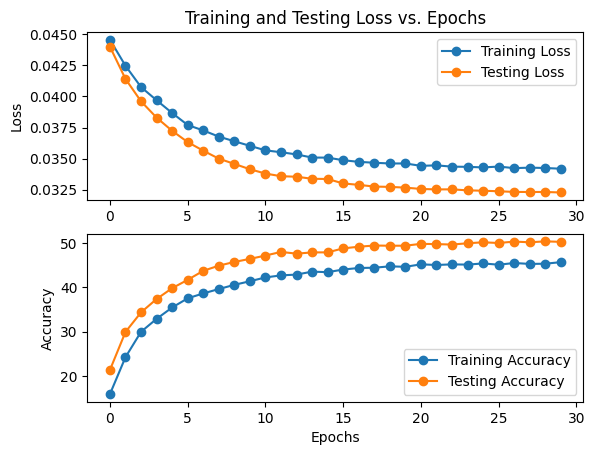

In [22]:
# 定义四个数组
train_loss_list5 = []
test_loss_list5 = []
train_acc_list5 = []
test_acc_list5 = []

# 将训练损失和准确率添加到相应的列表中
for loss in training_loss:
    train_loss_list5.append(loss)

for loss in testing_loss:
    test_loss_list5.append(loss)

for acc in training_acc:
    train_acc_list5.append(100 * acc)

for acc in testing_acc:
    test_acc_list5.append(100 * acc)

# 迭代了NUM_EPOCHS次
x = range(0, NUM_EPOCHS)

# 绘制训练损失和测试损失
plt.subplot(2, 1, 1)
plt.plot(x, train_loss_list5, label='Training Loss', marker='o')
plt.plot(x, test_loss_list5, label='Testing Loss', marker='o')
plt.title('Training and Testing Loss vs. Epochs')
plt.ylabel('Loss')
plt.legend()

# 绘制训练准确率和测试准确率
plt.subplot(2, 1, 2)
plt.plot(x, train_acc_list5, label='Training Accuracy', marker='o')
plt.plot(x, test_acc_list5, label='Testing Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 显示图形
plt.show()


In [23]:
model = ConvNet()
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)
loss_func = loss_function_6  # 选择要调用的损失函数
training_loss, training_acc, testing_loss, testing_acc = train_and_test_model(loss_func)

Epoch: 1/30 Train Loss: 1.0208 Acc: 0.2484
Begin test......
Test Loss: 0.8440 Acc: 0.3081
Epoch: 2/30 Train Loss: 0.8477 Acc: 0.3145
Begin test......
Test Loss: 0.8228 Acc: 0.3249
Epoch: 3/30 Train Loss: 0.8189 Acc: 0.3292
Begin test......
Test Loss: 0.7570 Acc: 0.3610
Epoch: 4/30 Train Loss: 0.8119 Acc: 0.3342
Begin test......
Test Loss: 0.7375 Acc: 0.3596
Epoch: 5/30 Train Loss: 0.7953 Acc: 0.3499
Begin test......
Test Loss: 0.7482 Acc: 0.3779
Epoch: 6/30 Train Loss: 0.7172 Acc: 0.3834
Begin test......
Test Loss: 0.6693 Acc: 0.3857
Epoch: 7/30 Train Loss: 0.6941 Acc: 0.3978
Begin test......
Test Loss: 0.6240 Acc: 0.4416
Epoch: 8/30 Train Loss: 0.6806 Acc: 0.4101
Begin test......
Test Loss: 0.6285 Acc: 0.4406
Epoch: 9/30 Train Loss: 0.6788 Acc: 0.4084
Begin test......
Test Loss: 0.6223 Acc: 0.4471
Epoch: 10/30 Train Loss: 0.6714 Acc: 0.4125
Begin test......
Test Loss: 0.6099 Acc: 0.4531
Epoch: 11/30 Train Loss: 0.6226 Acc: 0.4401
Begin test......
Test Loss: 0.5649 Acc: 0.4744
Epoch: 1

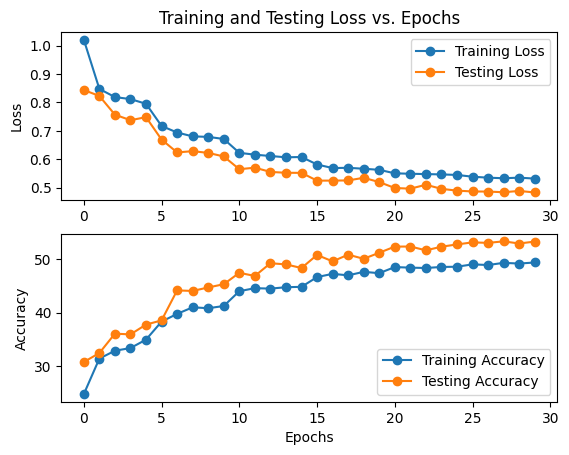

In [24]:
# 定义四个数组
train_loss_list6 = []
test_loss_list6 = []
train_acc_list6 = []
test_acc_list6 = []

# 将训练损失和准确率添加到相应的列表中
for loss in training_loss:
    train_loss_list6.append(loss)

for loss in testing_loss:
    test_loss_list6.append(loss)

for acc in training_acc:
    train_acc_list6.append(100 * acc)

for acc in testing_acc:
    test_acc_list6.append(100 * acc)

# 迭代了NUM_EPOCHS次
x = range(0, NUM_EPOCHS)

# 绘制训练损失和测试损失
plt.subplot(2, 1, 1)
plt.plot(x, train_loss_list6, label='Training Loss', marker='o')
plt.plot(x, test_loss_list6, label='Testing Loss', marker='o')
plt.title('Training and Testing Loss vs. Epochs')
plt.ylabel('Loss')
plt.legend()

# 绘制训练准确率和测试准确率
plt.subplot(2, 1, 2)
plt.plot(x, train_acc_list6, label='Training Accuracy', marker='o')
plt.plot(x, test_acc_list6, label='Testing Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 显示图形
plt.show()


### Task 2: Instance inference
---
The task is to visualizes an image along with model prediction and class probabilities.

**To do**: 
1. Calculate the prediction and the probabilities for each class.
         

In [25]:
inputs, classes = next(iter(test_dataloader))
input = inputs[0]

In [26]:
##################### Write your answer here ##################
# input: image, model
# outputs: predict_label, probabilities
# predict_label is the index (or label) of the class with the highest probability from the probabilities.
###############################################################
# Ensure the model is in evaluation mode
model.eval()

# Move the input image to the appropriate device (CPU or GPU)
input = input.to(device)

# Perform inference on the input image
with torch.no_grad():
    # Forward pass to get the class probabilities
    logits = model(input.unsqueeze(0))  # Ensure the image has the batch dimension (unsqueeze)
    probabilities = torch.softmax(logits, dim=1).squeeze(0).cpu().numpy()

# Find the predicted label by taking the class with the highest probability
predict_label = np.argmax(probabilities)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


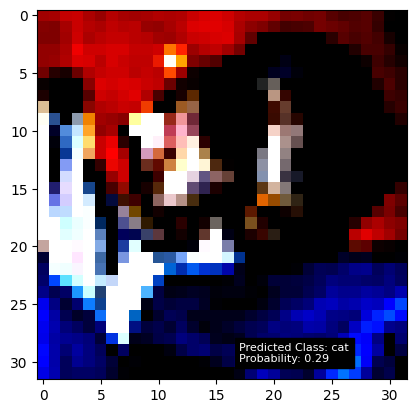

Print probabilities for each class:
airplane: 0.0363
automobile: 0.0403
bird: 0.1105
cat: 0.2850
deer: 0.0483
dog: 0.2505
frog: 0.0396
horse: 0.1094
ship: 0.0409
truck: 0.0391


In [27]:
predicted_class = class_names[predict_label.item()]
predicted_probability = probabilities[predict_label].item()
image = input.cpu().numpy().transpose((1, 2, 0))
plt.imshow(image)
plt.text(17, 30, f'Predicted Class: {predicted_class}\nProbability: {predicted_probability:.2f}', 
            color='white', backgroundcolor='black', fontsize=8)
plt.show()

# Print probabilities for each class
print('Print probabilities for each class:')
for i in range(len(class_names)):
    print(f'{class_names[i]}: {probabilities[i].item():.4f}')

/tmp/ipykernel_693936/1076861851.py:9: RuntimeWarning: divide by zero encountered in log
  losses_focal = [[-np.sum(np.where(target[i]==1, (1-pred[i])**gamma*(np.log(pred[i])), pred[i]**gamma*(np.log(1-pred[i])))) for i in range(len(pred))] for gamma in gammas]


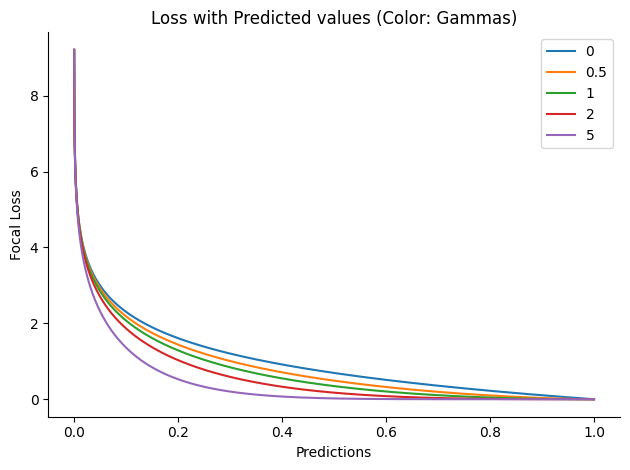

In [28]:
fig, ax1 = plt.subplots(1,1)

# array of same target value 10000 times
target = np.repeat(1, 10000) # considering prediction to be 1
pred = np.arange(0,1, 0.0001) # all predictions b/w 0 and 1 for 10k values

# calculating loss function for all predictions. 
gammas = [0, 0.5, 1, 2, 5]
losses_focal = [[-np.sum(np.where(target[i]==1, (1-pred[i])**gamma*(np.log(pred[i])), pred[i]**gamma*(np.log(1-pred[i])))) for i in range(len(pred))] for gamma in gammas]

# plot for binary cross entropy
for i in range(len(gammas)):
    ax1.plot(pred, losses_focal[i], label = gammas[i])
ax1.set_xlabel('Predictions')
ax1.set_ylabel('Focal Loss')
ax1.set_title("Loss with Predicted values (Color: Gammas)")
ax1.legend()

# make right and top lines invisible
ax1.spines['top'].set_visible(False)    # Make the top axis line for a plot invisible
ax1.spines['right'].set_visible(False) # Make the right axis line for a plot invisible

fig.tight_layout()

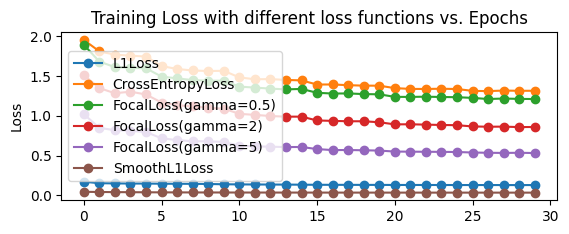

In [29]:
train_loss_list = [train_loss_list1, train_loss_list2, train_loss_list3, train_loss_list4, train_loss_list6, train_loss_list5]
train_loss_list_name = ['L1Loss', 'CrossEntropyLoss', 'FocalLoss(gamma=0.5)', 'FocalLoss(gamma=2)','FocalLoss(gamma=5)','SmoothL1Loss']
# 迭代了NUM_EPOCHS次
x = range(0, NUM_EPOCHS)
# 绘制训练损失和测试损失
plt.subplot(2, 1, 1)
for i in range(len(train_loss_list)):
    plt.plot(x, train_loss_list[i], label=train_loss_list_name[i], marker='o')
#plt.plot(x, test_loss_list, label='Testing Loss', marker='o')
plt.title('Training Loss with different loss functions vs. Epochs')
plt.ylabel('Loss')
plt.legend()
# 显示图形
plt.show()


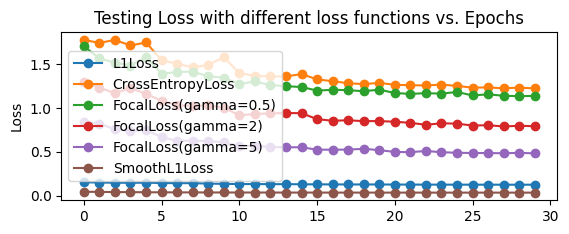

In [30]:
test_loss_list = [test_loss_list1, test_loss_list2, test_loss_list3, test_loss_list4, test_loss_list6, train_loss_list5]
test_loss_list_name = ['L1Loss', 'CrossEntropyLoss', 'FocalLoss(gamma=0.5)', 'FocalLoss(gamma=2)','FocalLoss(gamma=5)','SmoothL1Loss']
# 迭代了NUM_EPOCHS次
x = range(0, NUM_EPOCHS)
# 绘制训练损失和测试损失
plt.subplot(2, 1, 1)
for i in range(len(test_loss_list)):
    plt.plot(x, test_loss_list[i], label=test_loss_list_name[i], marker='o')
plt.title('Testing Loss with different loss functions vs. Epochs')
plt.ylabel('Loss')
plt.legend()
# 显示图形
plt.show()


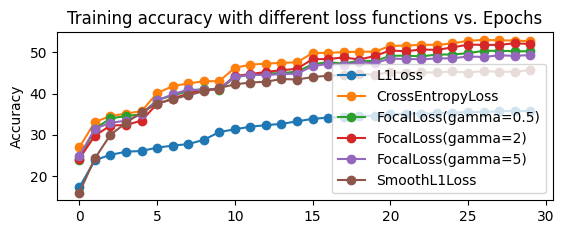

In [31]:
train_acc_list = [train_acc_list1, train_acc_list2, train_acc_list3, train_acc_list4, train_acc_list6, train_acc_list5]
train_acc_list_name = ['L1Loss', 'CrossEntropyLoss', 'FocalLoss(gamma=0.5)', 'FocalLoss(gamma=2)','FocalLoss(gamma=5)','SmoothL1Loss']
# 迭代了NUM_EPOCHS次
x = range(0, NUM_EPOCHS)
# 绘制训练损失和测试损失
plt.subplot(2, 1, 1)
for i in range(len(train_acc_list)):
    plt.plot(x, train_acc_list[i], label=train_acc_list_name[i], marker='o')
plt.title('Training accuracy with different loss functions vs. Epochs')
plt.ylabel('Accuracy')
plt.legend()
# 显示图形
plt.show()


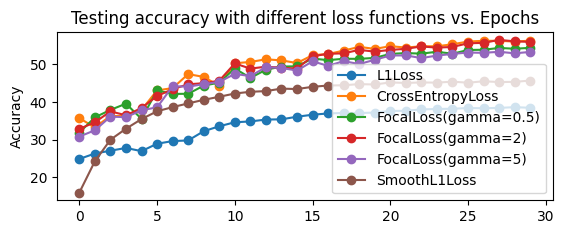

In [32]:
test_acc_list = [test_acc_list1, test_acc_list2, test_acc_list3, test_acc_list4, test_acc_list6, train_acc_list5]
test_acc_list_name = ['L1Loss', 'CrossEntropyLoss', 'FocalLoss(gamma=0.5)', 'FocalLoss(gamma=2)','FocalLoss(gamma=5)','SmoothL1Loss']
# 迭代了NUM_EPOCHS次
x = range(0, NUM_EPOCHS)
# 绘制训练损失和测试损失
plt.subplot(2, 1, 1)
for i in range(len(test_acc_list)):
    plt.plot(x, test_acc_list[i], label=test_acc_list_name[i], marker='o')
plt.title('Testing accuracy with different loss functions vs. Epochs')
plt.ylabel('Accuracy')
plt.legend()
# 显示图形
plt.show()
